# Planner Agent - plan and execute structured multistep tasks

We know the steps needs to be done ahead of time

user input -> planner -> executer (execute step by step and append the results in the intermediate messages) -> synthesizer -> output

## 0. Imports

In [ ]:
import os

from typing import List, TypedDict, Optional, Annotated
from pydantic import BaseModel, Field
from dotenv import load_dotenv
load_dotenv(override=True)


import json
from langchain_core.messages import AIMessage, HumanMessage

from langchain_tavily import TavilySearch
from langchain_nebius import ChatNebius
from langchain.tools import tool
from langchain_core.messages import AnyMessage, BaseMessage
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode 

# For pretty printing
from rich.console import Console
from rich.markdown import Markdown

console = Console()

In [ ]:
for key in ['TAVILY_API_KEY', 'TAVILY_API_KEY', 'NEBIUS_API_KEY']:
    if key not in os.environ:
        raise ValueError(f"Environment variable {key} is not set")

## 1. Setups

In [ ]:
import json
from pathlib import Path

# Create jobs directory if it doesn't exist
JOBS_DIR = Path("data/jobs")
JOBS_DIR.mkdir(exist_ok=True)

@tool
def load_job_by_title(job_title: str) -> str:
    """Load a job description by job title from the jobs directory"""
    # Search for files that contain the job title in their filename
    job_files = list(JOBS_DIR.glob("*.json"))
    
    for job_file in job_files:
        # Check if job title matches filename (case-insensitive)
        if job_title.lower() in job_file.stem.lower():
            with open(job_file, 'r') as f:
                job_data = json.load(f)
            return f"""Job: {job_data.get('title', 'Unknown')}
Company: {job_data.get('company', 'Unknown')}
Location: {job_data.get('location', 'Unknown')}
Description: {job_data.get('description', '')}
Requirements: {', '.join(job_data.get('requirements', []))}
Responsibilities: {', '.join(job_data.get('responsibilities', []))}
Salary: {job_data.get('salary_range', 'Not specified')}
Employment Type: {job_data.get('employment_type', 'Not specified')}
Experience Level: {job_data.get('experience_level', 'Not specified')}"""
    
    return f"Job with title '{job_title}' not found in directory"

@tool
def search_jobs_by_title(job_title: str) -> str:
    """Search for jobs by partial title match"""
    matching_jobs = []
    job_files = list(JOBS_DIR.glob("*.json"))
    
    for job_file in job_files:
        with open(job_file, 'r') as f:
            job_data = json.load(f)
        
        # Check if job title contains the search term
        if job_title.lower() in job_data.get('title', '').lower():
            matching_jobs.append(f"- {job_data.get('title', 'Unknown')} at {job_data.get('company', 'Unknown')} (File: {job_file.stem})")
    
    return f"Jobs matching '{job_title}':\n" + "\n".join(matching_jobs) if matching_jobs else f"No jobs found matching '{job_title}'"

@tool
def list_all_jobs() -> str:
    """List all available jobs with their titles and companies"""
    job_files = list(JOBS_DIR.glob("*.json"))
    if not job_files:
        return "No jobs found in directory"
    
    jobs = []
    for job_file in job_files:
        with open(job_file, 'r') as f:
            job_data = json.load(f)
        jobs.append(f"- {job_data.get('title', 'Unknown')} at {job_data.get('company', 'Unknown')} (File: {job_file.stem})")
    
    return "Available jobs:\n" + "\n".join(jobs)

@tool
def get_job_by_filename(filename: str) -> str:
    """Get job details by exact filename (without .json extension)"""
    job_file = JOBS_DIR / f"{filename}.json"
    if job_file.exists():
        with open(job_file, 'r') as f:
            job_data = json.load(f)
        return f"""Job: {job_data.get('title', 'Unknown')}
Company: {job_data.get('company', 'Unknown')}
Location: {job_data.get('location', 'Unknown')}
Description: {job_data.get('description', '')}
Requirements: {', '.join(job_data.get('requirements', []))}
Responsibilities: {', '.join(job_data.get('responsibilities', []))}
Salary: {job_data.get('salary_range', 'Not specified')}
Employment Type: {job_data.get('employment_type', 'Not specified')}
Experience Level: {job_data.get('experience_level', 'Not specified')}"""
    else:
        return f"Job file '{filename}.json' not found"

@tool
def search_jobs_by_criteria(criteria: str) -> str:
    """Search jobs by specific criteria (skills, location, etc.)"""
    matching_jobs = []
    for job_file in JOBS_DIR.glob("*.json"):
        with open(job_file, 'r') as f:
            job_data = json.load(f)
        
        # Search in title, description, requirements, and responsibilities
        searchable_text = f"{job_data.get('title', '')} {job_data.get('description', '')} {job_data.get('location', '')} {' '.join(job_data.get('requirements', []))} {' '.join(job_data.get('responsibilities', []))}".lower()
        
        if any(keyword.lower() in searchable_text for keyword in criteria.split()):
            matching_jobs.append(f"- {job_data.get('title', 'Unknown')} at {job_data.get('company', 'Unknown')} (File: {job_file.stem})")
    
    return f"Jobs matching '{criteria}':\n" + "\n".join(matching_jobs) if matching_jobs else f"No jobs found matching '{criteria}'"

In [ ]:
def job_aware_executor_node(state: PlannerState) -> PlannerState:
    """Executor that handles both general and job-specific steps."""
    console.print("--- EXECUTOR: Running next step... ---")

    plan = state["plan"] or []
    if not plan:
        return {"plan": []}

    next_step = plan[0]
    
    # Route to appropriate handler
    if next_step.startswith("web_search_tool"):
        # Web search logic
        import re
        m = re.search(r'web_search_tool\("(.+?)"\)', next_step)
        if not m:
            m = re.search(r"web_search_tool\('(.+?)'\)", next_step)
        if m:
            query = m.group(1)
            response = web_search_tool.invoke(query)
        else:
            response = "Error: Could not parse web search query"
            
    elif next_step.startswith("load_job_by_title"):
        # Load job by title
        import re
        m = re.search(r'load_job_by_title\("(.+?)"\)', next_step)
        if m:
            response = load_job_by_title.invoke(m.group(1))
        else:
            response = "Error: Could not parse job title"
            
    elif next_step.startswith("search_jobs_by_title"):
        # Search jobs by title
        import re
        m = re.search(r'search_jobs_by_title\("(.+?)"\)', next_step)
        if m:
            response = search_jobs_by_title.invoke(m.group(1))
        else:
            response = "Error: Could not parse search term"
            
    elif next_step.startswith("list_all_jobs"):
        # List all jobs
        response = list_all_jobs.invoke({})
        
    elif next_step.startswith("get_job_by_filename"):
        # Get job by filename
        import re
        m = re.search(r'get_job_by_filename\("(.+?)"\)', next_step)
        if m:
            response = get_job_by_filename.invoke(m.group(1))
        else:
            response = "Error: Could not parse filename"
            
    elif next_step.startswith("search_jobs_by_criteria"):
        # Search jobs by criteria
        import re
        m = re.search(r'search_jobs_by_criteria\("(.+?)"\)', next_step)
        if m:
            response = search_jobs_by_criteria.invoke(m.group(1))
        else:
            response = "Error: Could not parse search criteria"
            
    else:
        # General reasoning with job context
        job_prompt = f"""
        You are a recruitment and job analysis expert. Process this step:
        
        Step: {next_step}
        
        Provide expert analysis and recommendations. If this involves job analysis, 
        consider using the available job tools to get specific information.
        """
        response = llm.invoke(job_prompt).content

    console.print(f"--- EXECUTOR: {response[:100]}... ---")

    return {
        "plan": state["plan"][1:],
        "intermediate_messages": (state.get("intermediate_messages") or []) + [response]
    }

In [30]:
web_search = TavilySearch(api_key=os.environ["TAVILY_API_KEY"], max_results=2)

web_search.name = "web_search"
web_search.description = "Search the web for information"

@tool
def web_search_tool(query: str) -> str:
    """Search the web for information"""
    response = web_search.invoke(query)
    return str(response)


llm = ChatNebius(model="Qwen/Qwen3-14B", api_key=os.environ["NEBIUS_API_KEY"])
# Add job tools to your tool list
llm_with_tools = llm.bind_tools([
    web_search_tool, 
    load_job_by_title, 
    search_jobs_by_title,
    list_all_jobs,
    get_job_by_filename,
    search_jobs_by_criteria
])

In [35]:
class Plan(BaseModel):
    """
    A structured plan for a multi-step task
    """
    steps: List[str] = Field(description="A list of tool calls that, when executed, will answer the query.")

class PlannerState(TypedDict):
    """
    The state of the planner agent
    """
    user_input: str
    plan: Optional[List[str]] = None
    intermediate_messages: Optional[List[str]] = None
    messages: Annotated[List[BaseMessage], add_messages]
    final_output: Optional[str] = None

def planner_node(state: PlannerState) -> PlannerState:
    """
    Plan the steps for the task
    """
    console.print("--- PLANNER: Decomposing task... ---")
    PLANNER_SYSTEM = (
        "You are a planning agent with access to job data. Break down the task into steps. "
        "Available tools: "
        "- 'web_search_tool(\"query\")' for external information "
        "- 'load_job_by_title(\"job_title\")' to load a job by its title "
        "- 'search_jobs_by_title(\"partial_title\")' to search for jobs by partial title "
        "- 'list_all_jobs()' to see all available jobs "
        "- 'get_job_by_filename(\"filename\")' to load job by exact filename "
        "- 'search_jobs_by_criteria(\"criteria\")' to find relevant jobs "
        "When you have enough information to plan, output ONLY JSON: {\"steps\": [\"...\"]} with 4–7 concrete steps."
    )
    msgs = state.get("messages") or []
    if not msgs:
        # seed the conversation for the planner
        msgs = [
            HumanMessage(
                content=f"{PLANNER_SYSTEM}\n\nTask: {state['user_input']}"
            )
        ]

    # Let the planner take a turn. If it needs the tool it will emit tool_calls.
    planner_llm = llm.with_structured_output(Plan)

    ai = planner_llm.invoke(msgs)

    # Return only the new AI turn; add_messages merges it into the running history.
    console.print(f"--- PLANNER: Generated Plan: {ai} ---")

    return {"plan": ai.steps}

def executor_node(state: PlannerState) -> PlannerState:
    """Executes the next step in the plan."""
    console.print("--- EXECUTOR: Running next step... ---")

    plan = state["plan"] or []

    if not plan:
        return {"plan": []}

    next_step = plan[0]
    
    # Check if this step requires a tool call
    if next_step.startswith("web_search_tool"):
        # Handle web search tool call
        import re
        m = re.search(r'web_search_tool\("(.+?)"\)', next_step)
        if not m:
            m = re.search(r"web_search_tool\('(.+?)'\)", next_step)
        if m:
            query = m.group(1)
            response = web_search_tool.invoke(query)
        else:
            response = "Error: Could not parse web search query"
    else:
        # Handle non-tool steps (direct reasoning, calculations, etc.)
        console.print(f"--- EXECUTOR: Processing non-tool step: {next_step} ---")
        
        # Use LLM to process the step without tools
        step_prompt = f"""
        You are executing a step in a plan. Process this step and provide a response.
        
        Step: {next_step}
        
        Provide a clear, concise response based on your knowledge. If you need external information, 
        indicate that a web search would be needed.
        """
        
        response = llm.invoke(step_prompt).content

    console.print(f"--- EXECUTOR: {response} ---")

    return {
        "plan": state["plan"][1:],
        "intermediate_messages": (state.get("intermediate_messages") or []) + [response]
    }

def synthesizer_node(state: PlannerState) -> PlannerState:
    """Synthesizes the intermediate messages into a final output."""
    console.print("--- SYNTHESIZER: Synthesizing... ---")

    context = "\n".join(state["intermediate_messages"] or [])    

    prompt = f"""You are an expert synthesizer. Based on the user's input and the collected data, provide a comprehensive final answer.
    
    Request: {state['user_input']}
    Collected Data:
    {context}
    """
    final_output = llm.invoke(prompt).content
    return {"final_output": final_output}


def router_after_planner(state: PlannerState) -> str:
    msgs = state.get("messages") or []
    last = msgs[-1] if msgs else None
    # If the last AI turn requested any tools, go to ToolNode; else, parse the plan.
    return "tools" if getattr(last, "tool_calls", None) else "executer"

def router_function(state: PlannerState) -> str:
    if state.get("plan"):
        return "executer"
    else:
        return "synthesizer"

## Construct the graph

In [36]:
graph_builder = StateGraph(PlannerState)

graph_builder.add_node("planner", planner_node)
graph_builder.add_node("executer", job_aware_executor_node)
graph_builder.add_node("synthesizer", synthesizer_node)

graph_builder.set_entry_point("planner")

graph_builder.add_edge(
    "planner",
    "executer"
)


graph_builder.add_conditional_edges(
    "executer",
    router_function,   # returns "executer" if steps remain else "synthesizer"
    {"executer": "executer", "synthesizer": "synthesizer"}
)

graph_builder.add_edge("synthesizer", END)

planner_agent = graph_builder.compile()


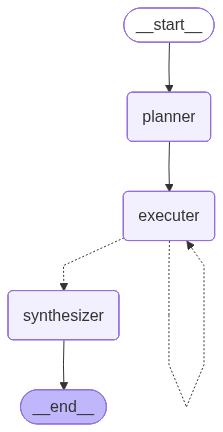

In [33]:
# This creates a PNG file of your graph
try:
    # Display the image in the notebook
    from IPython.display import display, Image
    png_image = planner_agent.get_graph().draw_mermaid_png()
    display(Image(png_image))
except Exception as e:
    print(f"Could not save image: {e}")
    print("You might need to install additional dependencies for image generation")


## Test the code

In [38]:
# Test with job-related queries
job_query = """
Analyze the AI Enabling Specialist job at NVIDIA. 
Provide guidance for someone applying to this position, including the total recommended preparation time, including daily interview preparation schedule and tips.
Use day 1 as a starting point.

"""

console.print(f"[bold green]Testing with job data:[/bold green] '{job_query}'\n")

initial_input = {
    "user_input": job_query, 
    "intermediate_messages": [],
    "messages": []
}

final_output = planner_agent.invoke(initial_input)
console.print("\n--- [bold green]Final Output[/bold green] ---")
console.print(Markdown(final_output['final_output']))

Testing with job data: '
Analyze the AI Enabling Specialist job at NVIDIA. 
Provide guidance for someone applying to this position, including the total recommended preparation time, including
daily interview preparation schedule and tips.
Use day 1 as a starting point.

'

--- PLANNER: Decomposing task... ---

--- PLANNER: Generated Plan: steps=['web_search_tool("AI Enabling Specialist job description NVIDIA")', 
'load_job_by_title("AI Enabling Specialist")', 'search_jobs_by_criteria("AI Enabling Specialist NVIDIA")', 
'list_all_jobs()', 'get_job_by_filename("ai_enabling_specialist_nvidia.json")', 'search_jobs_by_title("AI Enabling 
Specialist")', 'web_search_tool("How to prepare for AI Enabling Specialist interview NVIDIA")'] ---

--- EXECUTOR: Running next step... ---

--- EXECUTOR: {'query': 'AI Enabling Specialist job description NVIDIA', 'follow_up_questions': None, 'answer': 
No... ---

--- EXECUTOR: Running next step... ---

--- EXECUTOR: Job: AI Enabling Specialist - Finance
Company: NVIDIA
Location: US, AZ, Remote
Description: NVIDIA i... ---

--- EXECUTOR: Running next step... ---

--- EXECUTOR: Jobs matching 'AI Enabling Specialist NVIDIA':
- AI Enabling Specialist - Finance at NVIDIA (File: A... ---

--- EXECUTOR: Running next step... ---

--- EXECUTOR: Available jobs:
- AI Enabling Specialist - Finance at NVIDIA (File: AI Enabling Specialist)... ---

--- EXECUTOR: Running next step... ---

--- EXECUTOR: Job file 'ai_enabling_specialist_nvidia.json.json' not found... ---

--- EXECUTOR: Running next step... ---

--- EXECUTOR: Jobs matching 'AI Enabling Specialist':
- AI Enabling Specialist - Finance at NVIDIA (File: AI Enabl... ---

--- EXECUTOR: Running next step... ---

--- EXECUTOR: {'query': 'How to prepare for AI Enabling Specialist interview NVIDIA', 'follow_up_questions': 
None,... ---

--- SYNTHESIZER: Synthesizing... ---

--- Final Output ---

First, I need to structure the answer based on the job requirements. The role requires data engineering,           
automation, project management, and skills in SQL, Python, Databricks. The responsibilities involve guiding finance
teams, implementing AI tools, secure data integration, etc.                                                        

The preparation time should account for the candidate's current skill level. Since it's a mid to senior role, maybe
8-12 weeks for someone with relevant experience. But I should mention that it might vary.                          

Daily schedule: Split into technical, business, and interview practice. Maybe 4-5 hours a day. Week 1-2: Focus on  
technical skills. Week 3-4: Business processes and finance-specific knowledge. Weeks 5-8: Mock interviews and      
networking.                                                                                                        

Tips: Tailor the resume to the job description, highlight relevant projects, practice explaining technical         
concepts, understand NVIDIA's tech stack, prepare for behavioral questions, and study machine learning fundamentals
if needed.                                                                                                         

Check if the resources from the collected data can be used. The NVIDIA tips suggest reading the job description and
practicing technical skills. The interviewnode link mentions ML fundamentals and understanding the role.           

Make sure to include the salary info and mention the equity and benefits as a motivator. Also, note the remote     
option and location.                                                                                               

Need to ensure that the schedule is realistic, not too intense. Also, include tips on networking and staying       
updated with AI trends in finance. Maybe recommend Databricks certifications or courses if the candidate is weak in
that area.                                                                                                         

Avoid making the schedule too rigid but provide a structure. Emphasize the importance of both technical and soft   
skills since communication is a key requirement.                                                                   

Check for any missing info in the collected data. The job description is a bit brief, so maybe infer some          
responsibilities from the role description. For example, secure data integration might involve knowledge of        
compliance regulations, which is a good point to include in the preparation.                                       

Also, the candidate needs to understand how AI is applied in finance, so suggesting reading case studies or        
whitepapers on AI in financial processes could be helpful.                                                         


Finally, wrap it up with a summary of key points and encouragement to stay consistent with the preparation plan.   

Comprehensive Guide to Applying for NVIDIA’s AI Enabling Specialist (Finance) Role                                 
Preparation Plan, Daily Schedule, and Key Tips                                                                     

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                       1. Total Recommended Preparation Time                                       

8–12 weeks (depending on current skill level and experience). This timeline balances deep technical preparation,   
project-specific knowledge, and interview practice.                                                                

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                         2. Key Requirements & Focus Areas                                         

Based on the job description, prioritize